#Изучение данных и их подготовка

In [842]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import markdown 
import scipy.stats
import warnings
from matplotlib import pyplot as plt
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
pd.options.display.float_format = '{:.4f}'.format

In [843]:
df = pd.read_csv('drive/MyDrive/SuperStoreOrders.csv')
pd.set_option('display.max_columns', None)
df[:2]

,order_id,order_date,ship_date,ship_mode,customer_name,segment,state,country,market,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,year
0,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408,2,0.0000,106.1400,35.4600,Medium,2011
1,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120,3,0.1000,36.0360,9.7200,Medium,2011


In [844]:
df[df.duplicated()]

#проверяем данные на наличие дублей

,order_id,order_date,ship_date,ship_mode,customer_name,segment,state,country,market,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,year


In [845]:
df.info()

#проверяем данные и на будущее видим, что нет нулевых значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        51290 non-null  object 
 1   order_date      51290 non-null  object 
 2   ship_date       51290 non-null  object 
 3   ship_mode       51290 non-null  object 
 4   customer_name   51290 non-null  object 
 5   segment         51290 non-null  object 
 6   state           51290 non-null  object 
 7   country         51290 non-null  object 
 8   market          51290 non-null  object 
 9   region          51290 non-null  object 
 10  product_id      51290 non-null  object 
 11  category        51290 non-null  object 
 12  sub_category    51290 non-null  object 
 13  product_name    51290 non-null  object 
 14  sales           51290 non-null  object 
 15  quantity        51290 non-null  int64  
 16  discount        51290 non-null  float64
 17  profit          51290 non-null 

In [846]:
#убираем данные, которые не будут результативны для тех инструментов, которые мы планируем использовать во второй работе: тестирование гипотез,
#линейная и логистическая регрессия
#фактически, нам нужно оставить только количественные данные, но не будем пока полностью удалять качественные данные, просто выделим количественные в отдельный датафрейм

df_num = df[['sales', 'quantity', 'discount',	'profit', 'shipping_cost', 'year']]
df_num[:2]

,sales,quantity,discount,profit,shipping_cost,year
0,408,2,0.0000,106.1400,35.4600,2011
1,120,3,0.1000,36.0360,9.7200,2011


In [847]:
df_num.dtypes

sales             object
quantity           int64
discount         float64
profit           float64
shipping_cost    float64
year               int64
dtype: object

In [848]:
df_num.nunique()

sales             2246
quantity            14
discount            27
profit           24575
shipping_cost    10037
year                 4
dtype: int64

In [849]:
df_num.describe()

,quantity,discount,profit,shipping_cost,year
count,51290.0000,51290.0000,51290.0000,51290.0000,51290.0000
mean,3.4765,0.1429,28.6417,26.3759,2012.7772
std,2.2788,0.2123,174.4241,57.2968,1.0989
min,1.0000,0.0000,-6599.9780,0.0000,2011.0000
25%,2.0000,0.0000,0.0000,2.6100,2012.0000
50%,3.0000,0.0000,9.2400,7.7900,2013.0000
75%,5.0000,0.2000,36.8100,24.4500,2014.0000
max,14.0000,0.8500,8399.9760,933.5700,2014.0000


#Ответы на несколько вопросов с помощью базовой визуализации 

##Вопрос 1: самые продаваемые товары

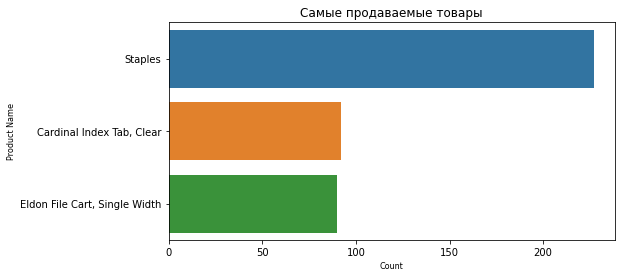

In [850]:
plt.figure(figsize=(8, 4))
sns.countplot(y='product_name', data=df, order=df['product_name'].value_counts().head(3).index)
plt.title('Самые продаваемые товары', fontsize=12)
plt.xlabel('Count', fontsize=8)
plt.ylabel('Product Name', fontsize=8)
plt.show()

In [851]:
top_sp = pd.DataFrame(df.groupby(['product_name']).sum()['quantity'])
top_sp.sort_values('quantity',ascending=False)[:3]

#вывод: самые продаваемые товары по количеству — это скобки, вкладыши и система хранения документов

,quantity
product_name,
Staples,876
"Cardinal Index Tab, Clear",337
"Eldon File Cart, Single Width",321


##Вопрос 2: какой регион дает наибольшие скидки

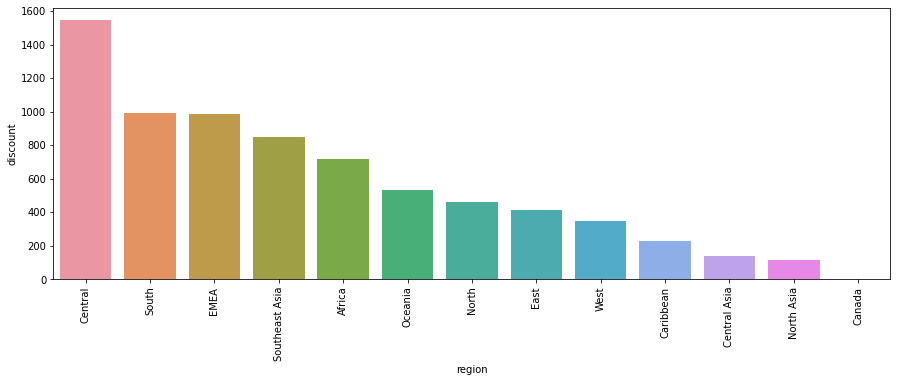

In [852]:
regions= df.groupby(['region']).sum().sort_values('discount', ascending=False)
regions.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='region', y='discount', data=regions)
plt.xticks(rotation=90)
plt.show();

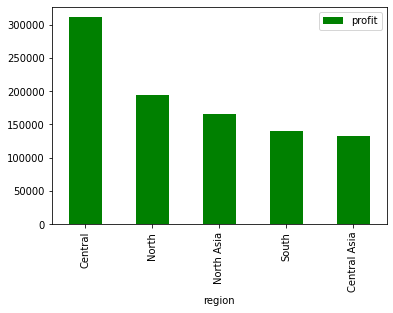

In [853]:
df.groupby(['region']).sum()[['profit']].sort_values(by="profit",ascending=False).nlargest(n=5, columns=['profit']).plot.bar(color="green")
plt.show()

#анализ показывает, что высокие скидки в Центральном регионе, и, несмотря на это, Центральный регион по-прежнему остается самым прибыльным

## Вопрос 3: какой способ доставки используют чаще всего



In [854]:
df['ship_mode'].value_counts()

Standard Class    30775
Second Class      10309
First Class        7505
Same Day           2701
Name: ship_mode, dtype: int64

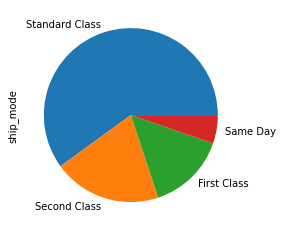

In [855]:
df['ship_mode'].value_counts().plot.pie()

#круговая диаграмма показывает, что чаще всего заказы доставляются с помощью стандартного класса

## Вопрос 4: общая прибыль и убытки в 2011-2014 годах

In [856]:
df_profit=df[df['profit'] > 0]
df_loss=df[df['profit'] < 0]
df_loss.shape, df_profit.shape
#определяем прибыль и убытки, распределяя их в разные датафреймы и смотрим количество внутри

((12543, 21), (38079, 21))

In [857]:
#рассчитываем общую прибыль
Total_Profit = df_profit['profit'].sum()
Total_Profit

2389392.212

In [858]:
#рассчитываем убытки, округляя до 2 знаков после запятой
Total_loss=np.negative(df_loss['profit'].sum())
Total_loss

920357.39072

In [859]:
#расчитаем доход
Net_Profit = Total_Profit - Total_loss
Net_Profit

1469034.8212799998

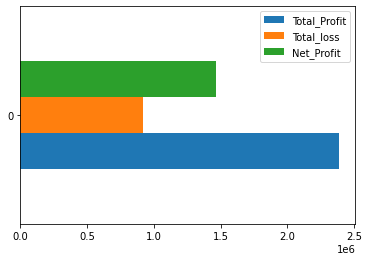

In [860]:
#визуализируем результат
df_Net_Profit=pd.DataFrame({'Total_Profit': {0: 2389392},
                            'Total_loss':{0: 920357},
                            '         ':{0: '='},
                            'Net_Profit':{0: 1469035}})
df_Net_Profit.plot(kind='barh')

#Продвинутая визуализация

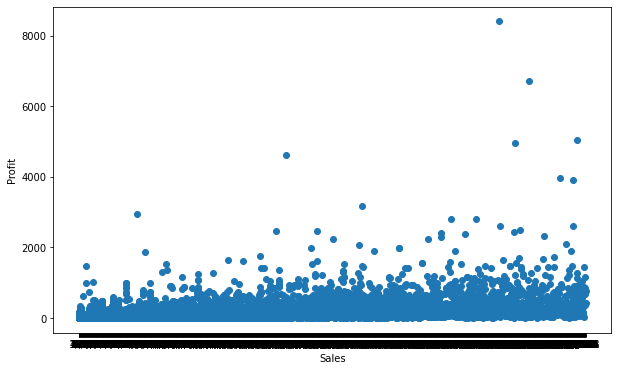

In [861]:
#посмотрим связь между продажами и доходом с помощью графика рассеивания
fig, ax = plt.subplots(figsize = (10 , 6))
ax.scatter(df_profit["sales"] , df_profit["profit"])
ax.set_xlabel('Sales')
ax.set_ylabel('Profit')
plt.show()

#судя по графику, яркой связи нет

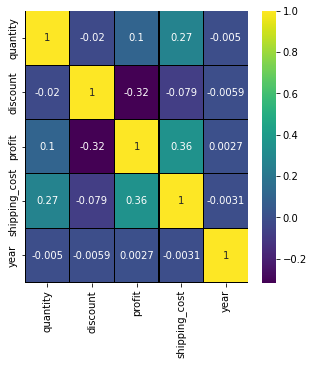

In [862]:
#строим корреляционную матрицу

correlation = df_num.corr()
fig , ax = plt.subplots(figsize = (5,5))
sns.heatmap(correlation, 
            linewidths=0.1, annot=True,cmap='viridis',
            linecolor="black", annot_kws = {'size':10})

#результаты корреляционной матрицы показывают, что нет значений с сильной зависимостью, максимальный коэффициент детерминации = 0.36 и показывает слабую степерь корреляции

Text(0.5, 0.98, 'Диаграммы для количественных переменных')

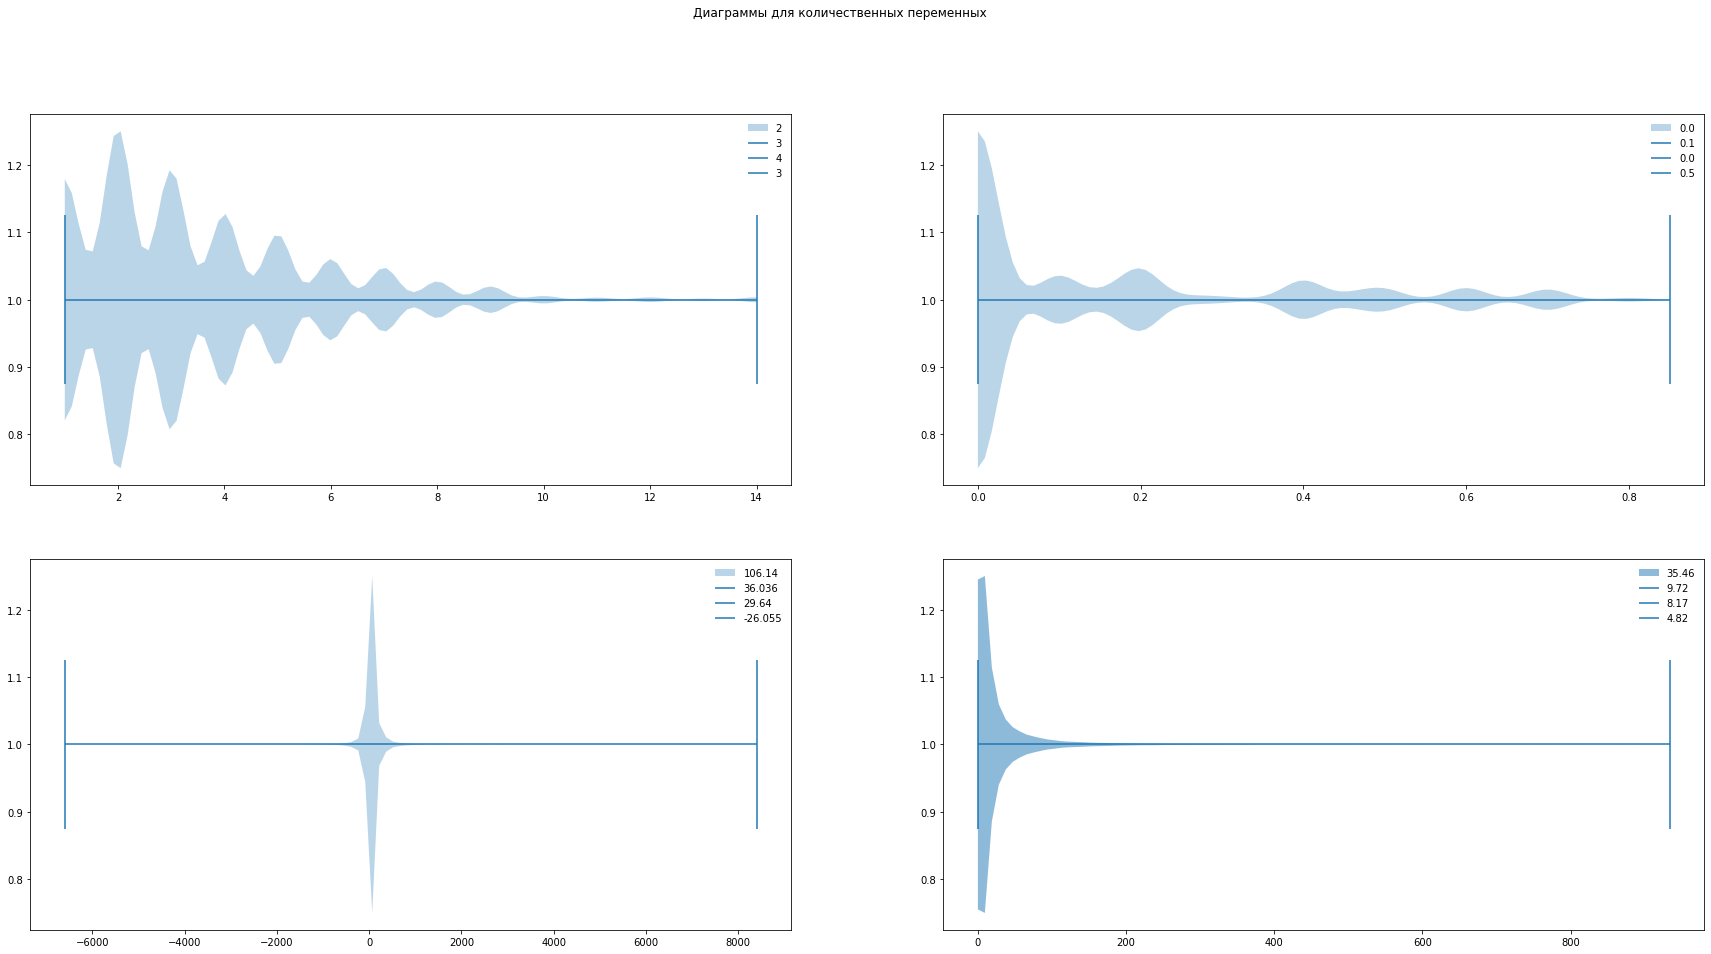

In [863]:
#Построим графики  для ряда количественных переменных, чтобы визуально оценить наличие выбросов
#брать 'year' не будем, так как там не может быть выборосов

fig, ax = plt.subplots(2,2, figsize=(30,15))

violin_target = ax[0][0].violinplot(df_num['quantity'],vert=False)
violin_target = ax[0][1].violinplot(df_num['discount'],vert=False)
violin_target = ax[1][0].violinplot(df_num['profit'],vert=False)
violin_target = ax[1][1].violinplot(df_num['shipping_cost'],vert=False)

for vp in violin_target['bodies']:
    vp.set_linewidth(1)
    vp.set_alpha(0.5)

ax[0][0].legend(df_num['quantity'],frameon=False)
ax[0][1].legend(df_num['discount'],frameon=False)
ax[1][0].legend(df_num['profit'],frameon=False)
ax[1][1].legend(df_num['shipping_cost'],frameon=False)

fig.suptitle('Диаграммы для количественных переменных')

#графики показывают, что данные 'quantity' и 'discount' не подразумевают выбросов, поэтому дальше для выбросов можно поверить оставшиеся 2 значения, у которых визуально есть выбросы

#Выбросы

In [864]:
#рассчитаем выбросы для категории 'profit' 
mean_df_num = df_num['profit'].mean()
std_df_num = df_num['profit'].std()
std_threshold_bottom_df_num = mean_df_num - 3 * std_df_num
std_threshold_top_df_num = mean_df_num + 3 * std_df_num
print(std_threshold_bottom_df_num, std_threshold_top_df_num)

-494.630599406247 551.9140784969079


In [865]:
df_num.shape

(51290, 6)

In [866]:
#проверяем выбросов по переменной по верхней границе
df_num[df_num['profit'] > std_threshold_top_df_num].shape

#всего 579 выбросов

(579, 6)

In [867]:
#проверяем выбросы по переменной по нижней границе
df_num[df_num['profit'] < std_threshold_bottom_df_num].shape

#всего 287 выбросов

(287, 6)

In [868]:
#ограничиваем датасет сверху 

df_num = df_num[df_num['profit'] < std_threshold_top_df_num]
df_num.shape

(50711, 6)

In [869]:
#ограничиваем датасет снизу 
df_num = df_num[df_num['profit'] > std_threshold_bottom_df_num]
df_num.shape

(50424, 6)

In [870]:
#рассчитаем выбросы для категории 'shipping_cost' 

mean_df_num = df_num['shipping_cost'].mean()
std_df_num = df_num['shipping_cost'].std()
std_threshold_bottom_df_num = mean_df_num - 3 * std_df_num
std_threshold_top_df_num = mean_df_num + 3 * std_df_num
print(std_threshold_bottom_df_num, std_threshold_top_df_num)

-117.4005649637887 163.70920926015552


In [871]:
#проверяем выбросов по переменной по верхней границе
#по нижней границе проверять не будем, так как отрицательной скидка не бывает, а наша нижняя граница отрицательная
#и сразу перезаписываем датасет

df_num = df_num[df_num['shipping_cost'] > std_threshold_top_df_num]

#всего 1024 выбросa

{'whiskers': [<matplotlib.lines.Line2D at 0x7efcce86a130>,
 'caps': [<matplotlib.lines.Line2D at 0x7efcce86ab80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7efcce86a730>],
 'medians': [<matplotlib.lines.Line2D at 0x7efccdcade50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7efccdcad520>],
 'means': []}

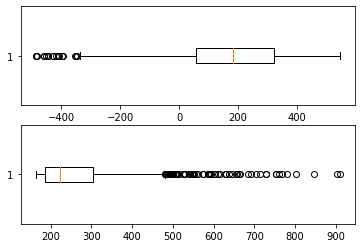

In [872]:
#после ограничения данных у нас должны остаться датасеты без выбросов
#построим графики "ящик с усами" для всех количественных переменных, чтобы визуально оценить отсутствие выбросов

fig, axs = plt.subplots(2)
axs[0].boxplot(df_num['profit'], vert = False)
axs[1].boxplot(df_num['shipping_cost'], vert = False)

#Тестирование гипотез




###Непараметрический критерий: хи-квадрат

In [873]:
#сгруппируем данные "profit"

def get_profit_cut(profit):
    if profit > 0:
        return 1
    else:
        return 0

In [874]:
df_num['profit_cat'] = df_num['profit'].apply(get_profit_cut)
df_num[:2]

,sales,quantity,discount,profit,shipping_cost,year,profit_cat
83,"2,479",6,0.0000,49.5000,349.8700,2011,1
84,"2,174",7,0.0000,260.8200,275.5200,2011,1


####Н0

In [875]:
#строим таблицу сопряженности. нелевая гипотеза — гипотеза об отсутствии зависимости. предположим, что от года к году какой-то прошлый опыт никак не влиял на нашу прибыль

ct_o = df_num.groupby('year')['profit_cat'].value_counts().unstack()
ct_o

profit_cat,0,1
year,,
2011,28,147
2012,40,171
2013,47,228
2014,58,305


In [876]:
alpha = 0.01
#берем вероятность ошибки первого рода в 1%
dof = (4-1)*(2-1)
dof = 3

critical_value = 11.3 
#по таблице распределения хи-квадрат

In [877]:
n_total = ct_o.sum().sum()

#получили количество наблюдений и посчитаем теоретические частоты

In [878]:
f_e_2011_0 = ct_o[0].sum() * ct_o.iloc[0].sum() / n_total

In [879]:
f_e_2012_0 = ct_o[0].sum() * ct_o.iloc[1].sum() / n_total

In [880]:
f_e_2013_0 = ct_o[0].sum() * ct_o.iloc[2].sum() / n_total

In [881]:
f_e_2014_0 = ct_o[0].sum() * ct_o.iloc[3].sum() / n_total

In [882]:
f_e_2011_1 = ct_o[1].sum() * ct_o.iloc[0].sum() / n_total

In [883]:
f_e_2012_1 = ct_o[1].sum() * ct_o.iloc[1].sum() / n_total

In [884]:
f_e_2013_1 = ct_o[1].sum() * ct_o.iloc[2].sum() / n_total

In [885]:
f_e_2014_1 = ct_o[1].sum() * ct_o.iloc[3].sum() / n_total

In [886]:
#собираем все в матрицу

ct_e = np.array([[f_e_2011_0, f_e_2011_1],
                 [f_e_2012_0, f_e_2012_1],
                 [f_e_2013_0, f_e_2013_1],
                 [f_e_2014_0, f_e_2014_1]])
ct_e

array([[ 29.56542969, 145.43457031],
       [ 35.64746094, 175.35253906],
       [ 46.45996094, 228.54003906],
       [ 61.32714844, 301.67285156]])

In [887]:
chi_square = ((ct_o - ct_e)**2 / ct_e).sum().sum()

In [888]:
chi_square > critical_value

#гипотеза не подтвердилась

False

In [889]:
#проверим результат
chi_square2 = scipy.stats.chi2_contingency(ct_o)[0]

In [890]:
chi_square2 > critical_value

#действительно гипотеза не подтверждается

False

####H1: объем скидки влияет на то, что мы получаем положительный доход

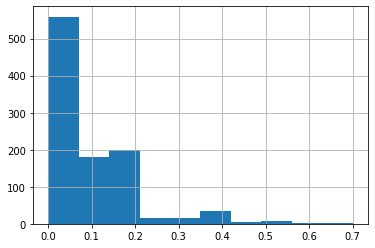

In [891]:
#смотрим распределение данных discount, чтобы определить группировку

df_num.discount.hist()

In [892]:
#сгруппируем данные "discount". возьмем простую группировку, в которой скидка меньше 50% -- низкая, выше -- высокая и закодируем это под 0 и 1

def get_discount_cat(discount):
    if discount < 0.5:
        return 0
    else:
        return 1
df_num['discount_cat'] = df_num['discount'].apply(get_discount_cat)

In [893]:
df_num[:2]

,sales,quantity,discount,profit,shipping_cost,year,profit_cat,discount_cat
83,"2,479",6,0.0000,49.5000,349.8700,2011,1,0
84,"2,174",7,0.0000,260.8200,275.5200,2011,1,0


In [894]:
ct_o = df_num.groupby('profit_cat')['discount_cat'].value_counts().unstack()
ct_o

discount_cat,0,1
profit_cat,,
0,161.0000,12.0000
1,851.0000,NaN


In [895]:
alpha = 0.05
critical_value = 6.63

In [896]:
chi_square = scipy.stats.chi2_contingency(ct_o)[0]

In [897]:
chi_square > critical_value

#гипотеза не подвердилась 

False

###Параметрический критерий: t-тест

In [898]:
#нулевая гипотеза: доход зависит от размера скидки
df_num[:2]

,sales,quantity,discount,profit,shipping_cost,year,profit_cat,discount_cat
83,"2,479",6,0.0000,49.5000,349.8700,2011,1,0
84,"2,174",7,0.0000,260.8200,275.5200,2011,1,0


In [899]:
#формируем две подгруппы
high_discount = df_num[df_num['discount_cat'] == 1]['profit'] 
small_discount = df_num[df_num['discount_cat'] == 0]['profit'] 

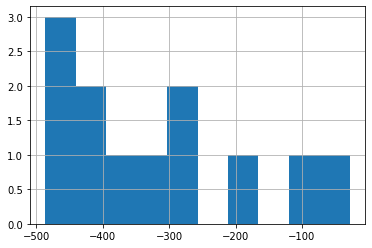

In [900]:
#смотрим распределение

high_discount.hist()

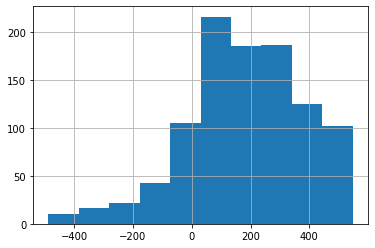

In [901]:
small_discount.hist()

In [902]:
#рассчитаем дисперсию 
print(high_discount.var())
print(small_discount.var())

22077.36976534061
38836.84688885037


In [903]:
#рассчитываем показатели
n_high = len(high_discount)   
n_small = len(small_discount)
var_high = high_discount.var()
var_small = small_discount.var()

In [904]:
v_high = var_high / n_high
v_small = var_small / n_small
dof = (v_high + v_small)**2 / (v_high**2 / (v_high - 1) + v_small**2 / (v_small - 1))
print(dof)

1876.1320318814408


In [905]:
def hypothesis_check(t, t_critical):
    if abs(t) > t_critical:
        print('Отвергаем НО. Разница между средними статистически значима.')
    else:
        print('Не удалось отвергнуть НО')
        
t_critical = 3.1058

In [906]:
s_sum = np.sqrt(v_high + v_small)
s_sum

43.33771042286637

In [907]:
mean_high = high_discount.mean()
mean_small = small_discount.mean()
mean_high, mean_small

(-312.4988666666667, 182.88625132411067)

In [908]:
#рассчитываем значение t
t = (mean_high - mean_small)/ s_sum  
t

-11.430809638005154

In [909]:
hypothesis_check(t, t_critical)

Отвергаем НО. Разница между средними статистически значима.


#Построение линейной регрессии

In [910]:
df_num

,sales,quantity,discount,profit,shipping_cost,year,profit_cat,discount_cat
83,"2,479",6,0.0000,49.5000,349.8700,2011,1,0
84,"2,174",7,0.0000,260.8200,275.5200,2011,1,0
100,"2,875",5,0.1000,511.0950,665.2700,2011,1,0
125,"1,384",3,0.0000,13.7700,178.9800,2011,1,0
173,"1,326",5,0.0000,238.6530,187.6500,2011,1,0
...,...,...,...,...,...,...,...,...
51034,"1,535",3,0.1000,-102.4110,255.4200,2014,0,0
51035,"1,104",4,0.1000,208.6080,182.2000,2014,1,0
51150,"1,094",6,0.0000,317.1600,184.6000,2014,1,0
51228,"1,264",5,0.0020,301.4660,253.2500,2014,1,0


In [911]:
df_num1 = df_num[['quantity', 	'discount', 	'profit', 	'shipping_cost']].head(1000)

#причем, ограничили данные до первой тысячи, иначе далее функции выполняются очень медленно

In [912]:
df_num1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 83 to 50067
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   quantity       1000 non-null   int64  
 1   discount       1000 non-null   float64
 2   profit         1000 non-null   float64
 3   shipping_cost  1000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 39.1 KB


In [913]:
df_num1['quantity'] = df_num1['quantity'].astype(float)

In [914]:
df_num1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 83 to 50067
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   quantity       1000 non-null   float64
 1   discount       1000 non-null   float64
 2   profit         1000 non-null   float64
 3   shipping_cost  1000 non-null   float64
dtypes: float64(4)
memory usage: 39.1 KB


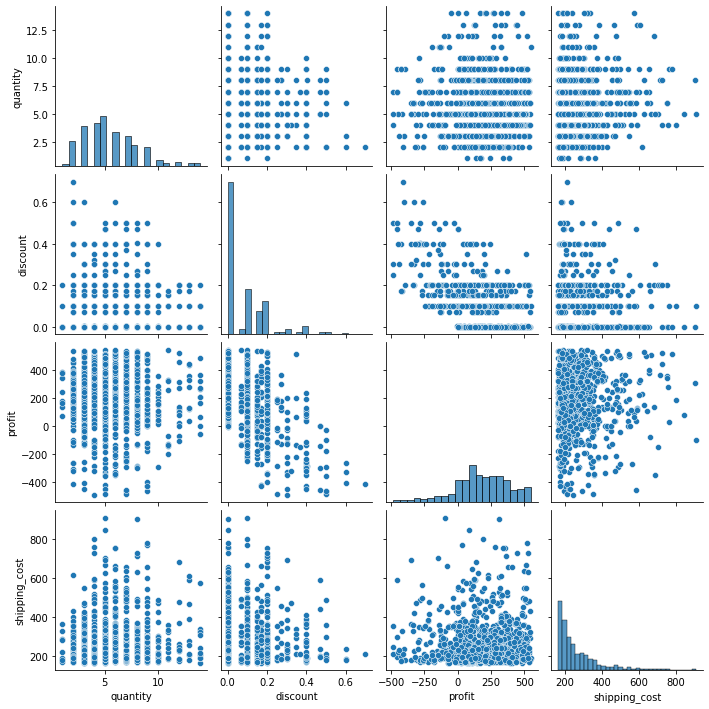

In [915]:
sns.pairplot(df_num1)

#проверяем переменные на наличие корреляции и видим, что линейных взаимосвязей нет

In [916]:
X = df_num1['shipping_cost']
y = df_num1['profit']

res = scipy.stats.linregress(X, y)
print(res)
#строим модель зависимости прибыли от стоимости доставки

LinregressResult(slope=0.06624105332082732, intercept=158.8767923885406, rvalue=0.038089963727442035, pvalue=0.22880585230376768, stderr=0.055009300709166986, intercept_stderr=16.003100916079283)


In [917]:
r_sq = res.rvalue ** 2
print(r_sq)

#коэффициент детерминации показывает слабую связь. проверим также на графике

0.00145084533675785


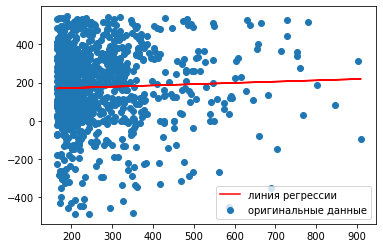

In [918]:
plt.scatter(X, y, label = 'оригинальные данные')
plt.plot(X, res.intercept + res.slope * X, 'r', label = 'линия регрессии')
plt.legend()
plt.show()

#по графику видим, что связь есть, однако не сильная: при значительно росте цены на доставку прибыль увеличивается незначительно

#Множественная линейная регрессия

In [919]:
#выбираем зависимую (Y) и независимые переменные (X) для построения множественной линейной регрессии
import statsmodels.api as sm

X_mult = df_num1.drop(columns='profit', axis=1)
Y = df_num1['profit']
X_mult_constant = sm.add_constant(X_mult)

mod = sm.OLS(y, X_mult_constant)
res_mult = mod.fit()
print(res_mult.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     123.2
Date:                Wed, 14 Dec 2022   Prob (F-statistic):           7.60e-68
Time:                        19:30:15   Log-Likelihood:                -6574.2
No. Observations:                1000   AIC:                         1.316e+04
Df Residuals:                     996   BIC:                         1.318e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           243.4505     17.323     14.054

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [920]:
'''интерпретация модели показывает, что:
1 - модель может описать только 34% данных
2 - вероятность того, что коэффициенты при всех переменных равны нулю очень низкая
3 - наиболее хорошо измерен коэффициент shipping_cost, так как у него наиболее значение t
4 - переменная quantity не влияет на зависимую переменную profit с вероятностью 15.1%
5 - переменная discount не влияет на зависимую переменную profit с вероятностью 0%
6 - 5 - переменная shipping_cost не влияет на зависимую переменную profit с вероятностью 0%
7 - данные распределены не нормально'''

'интерпретация модели показывает, что:\n1 - модель может описать только 34% данных\n2 - вероятность того, что коэффициенты при всех переменных равны нулю очень низкая\n3 - наиболее хорошо измерен коэффициент shipping_cost, так как у него наиболее значение t\n4 - переменная quantity не влияет на зависимую переменную profit с вероятностью 15.1%\n5 - переменная discount не влияет на зависимую переменную profit с вероятностью 0%\n6 - 5 - переменная shipping_cost не влияет на зависимую переменную profit с вероятностью 0%\n7 - данные распределены не нормально'

#Логистическая регрессия

In [951]:
#делим данные 2 выборки - train и  test, для проверки модели. создадим новый датасет, в который включим только те данные, которые можем перевести в int64 для обучения модели

df_num2 = df[['quantity', 'discount',	'profit']]

X = df_num2.drop(columns='profit', axis=1)
Y = df_num2['profit']

from sklearn.model_selection import train_test_split, cross_val_predict
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

print(X.shape, X_train.shape, X_test.shape)

(51290, 2) (38467, 2) (12823, 2)


In [952]:
round(len(X_train) / len(X_test), 1)

#соотношение = 1 к 3

3.0

In [953]:
#обучение

from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
reg = LinearRegression()
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
score = cross_val_score(reg, X, Y, cv = 10)

#количество вариаций = 10

In [954]:
#сгруппируем данные "profit"

def get_profit_cat(profit):
    if profit > 0:
        return 1
    else:
        return 0

In [943]:
df_num2['profit'] = df_num2['profit'].apply(get_profit_cat)

<ipython-input-943-3a680c4cc616>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num2['profit'] = df_num2['profit'].apply(get_profit_cat)


In [947]:
#сгруппируем данные "discount". возьмем простую группировку, в которой скидка меньше 50% -- низкая, выше -- высокая и закодируем это под 0 и 1

def get_discount_cat(discount):
    if discount < 0.5:
        return 0
    else:
        return 1
df_num2['discount'] = df_num2['discount'].apply(get_discount_cat)

<ipython-input-947-3b510c057338>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num2['discount'] = df_num2['discount'].apply(get_discount_cat)


In [955]:
df_num2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   quantity  51290 non-null  int64  
 1   discount  51290 non-null  float64
 2   profit    51290 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.2 MB


In [957]:
lin_reg_coefs = pd.DataFrame({'Коэффициент' : reg.coef_,
                    'Независимые переменные' : ['quantity', 	'discount']})
lin_reg_coefs = lin_reg_coefs.append({'Коэффициент' : reg.intercept_,
                   'Зависимая переменная' : 'profit_cat'}, ignore_index = True)

lin_reg_coefs

,Коэффициент,Независимые переменные,Зависимая переменная
0,7.3123,quantity,NaN
1,-261.1037,discount,NaN
2,39.4872,NaN,profit_cat


In [958]:
log_regression = LogisticRegression()

#обучаем модель
log_regression.fit(X_train, Y_train)

#применяем модель для прогнозирования
y_pred = log_regression.predict(X_test)

ValueError: ignored

In [959]:
log_reg = LogisticRegression()
log_reg.fit(X_train, Y_train)
Y_pred = log_reg.predict(X_test)

ValueError: ignored

In [ ]:
#итог: обучение модели не получилось, так как из-за ошибки ValueError: Unknown label type: 'continuous'

#Выводы

В результате данной работы были затронуты следующие темы:
- фильтрация и группировка
- выбросы
- непараметрическое тестирование гипотез
- параметрическое тестирование гипотез
- корреляция
- линейная реграссия
- логистическая регрессия

Были проверен ряд гипотез, однако изучена только часть датасета, так как в первую очередь инстурменты были направлены на работу с количественными данными, коих было представлено в датасете не много. Более того, не все данный можно было перевести в бинарные без потери сути, поэтому объемы данных значительно сократились.
Однако в существующих условиях удалось продемонстрировать полученные навыки. 